-----------------------------
-----------------------------

# Random Forests, SVMs and Neural Networks 
In this notebook, three classifiers will be tuned and compared for the classification of cars using the given dataset.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

import sklearn
import sklearn.svm as svm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,\
     precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

from google.colab import drive
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import time

# Data Preparation
First the data is prepared, which involves some cleaning and transformation of classes into numerical variables. 

In [0]:
# Load data from my drive into dataframes
drive.mount("/content/drive/")
train = pd.read_csv("/content/drive/My Drive/A50/CW2/train_set.csv")
test = pd.read_csv("/content/drive/My Drive/A50/CW2/test_set.csv")

train.head()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


,Unnamed: 0,buying,maint,doors,persons,lug_boot,safety,rating
0,0,low,med,3,4,small,high,good
1,0,vhigh,vhigh,2,2,small,low,good
2,0,med,med,5more,4,med,high,good
3,0,low,med,3,4,small,high,unacc
4,0,vhigh,vhigh,2,2,small,low,unacc


In [0]:
# Remove unnamed column
train = train.drop(['Unnamed: 0'], axis=1)
test = test.drop(['Unnamed: 0'], axis=1)

# Display all categories for each column
for col in train:
    print(col, train[col].unique())

buying ['low' 'vhigh' 'med' 'high']
maint ['med' 'vhigh' 'low' 'high']
doors ['3' '2' '5more' '4']
persons ['4' '2' 'more']
lug_boot ['small' 'med' 'big']
safety ['high' 'low' 'med']
rating ['good' 'unacc' 'vgood' 'acc']


## Ranked Classes
- I will now map the categories onto numbers, since all categories are **ranked** (eg. maint is ordered as low, med, high, vhigh). This means our predictors retain information about distances between them (ie the different between 'low' and 'med' is smaller than that or 'low' and 'vhigh'). However this is not perfect, as this assumes that, for example, if we map doors [2, 3, 4, 5more] onto [1, 2, 3, 4], the distances between doors=2 and doors=3 is the same as that of doors=4 and doors=5more. However, the 5more doors could correspond to cars with more than 5 doors, which suggests we should consider mapping 5more onto a number slightly bigger than 4. 
- I plot the distributions of all variables to make sure there is not a disproportionate number of entries for classes such as '5more doors' and 'more persons'.

In [0]:
# Map ranked classes onto numbers
for df in [train, test]:
    df['buying'] = df['buying'].replace(['low', 'med', 'high', 'vhigh'], [1, 2, 3, 4]) #0,1,2,3? -1.5,-.5, .5 1.5? 1/8, 3/8, 5/8, 7/8?
    df['maint'] = df['maint'].replace(['low', 'med', 'high', 'vhigh'], [1, 2, 3, 4]) #0,1,2,3? -1.5,-.5, .5 1.5? 1/8, 3/8, 5/8, 7/8?
    df['doors'] = df['doors'].replace(['2', '3', '4', '5more'], [1, 2, 3, 4]) #0,1,2,3? -1.5,-.5, .5 1.5? 1/8, 3/8, 5/8, 7/8?
    df['persons'] = df['persons'].replace(['2', '4', 'more'], [1, 2, 3]) #0,1,2,3? -1.5,-.5, .5 1.5? 1/8, 3/8, 5/8, 7/8?
    df['lug_boot'] = df['lug_boot'].replace(['small', 'med', 'big'], [1, 2, 3]) #0,1,2,3? -1.5,-.5, .5 1.5? 1/8, 3/8, 5/8, 7/8?
    df['safety'] = df['safety'].replace(['low', 'med', 'high'], [1, 2, 3]) #0,1,2,3? -1.5,-.5, .5 1.5? 1/8, 3/8, 5/8, 7/8?
    df['rating'] = df['rating'].replace(['unacc', 'acc', 'good', 'vgood'], [1, 2, 3, 4]) #0,1,2,3? -1.5,-.5, .5 1.5? 1/8, 3/8, 5/8, 7/8?

# Make a list of predictors
predictors = train.columns.drop('rating')

# Split into X and y
X_train_full = train[predictors]
y_train_full = train['rating']
X_test_full = test[predictors]
y_test_full = test['rating']

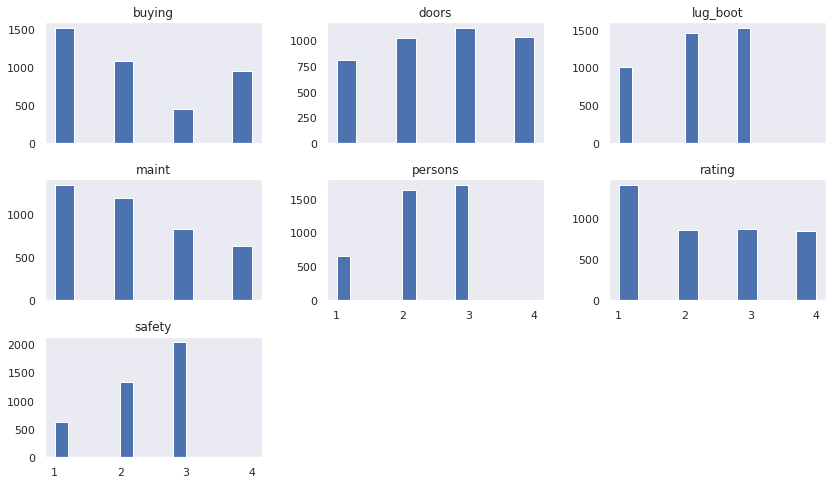

In [0]:
# Make a simple plot for the histograms of columns
hist = train.hist(figsize=(14,8), sharex=True, grid=False)

The plots for the columns seemed relatively sensible, including the '5more' and '5doors' classes for persons and doors, and so there is no obvious need to further transform the data based on this (apart from the standardization and balancing of this data later on.)

# Balancing Data
- Classification methods are likely to work better if the models are trained on balanced datasets (that is, that the classes that the model is trying to predict are balanced in frequency). Without balancing, the model is likely to missclassify less frequent classes, since it has less information about these classes and is penalized less for missclassifying them since there are fewer of them (in the case that we are using accuracy as a performance metric).

- The size of the classes also has to be decided. If the size is too large (so many classes will be oversampled), the model will tend to overfit, since repeated values of smaller classes are trained on. If the size is too small (so many classes will be undersampled), then useful data might be removed, and the model might not describe the data as well, and will perform poorly on both in-sample and out-of-sample data.
--------
- The training datasets should be **balanced inside the cross-validation splits**, so that each training set for each fold is balanced separately, and the validation set for each fold is not balanced, so that the evaulation is more realistic. This is important since **if the dataset is balanced before cross validation, then the validation set will be balanced**. However this **is not the desired validation set**, since we should assume that real out-of-sample data has a similar distribution of classes to the unbalanced training data.
--------
- In order to tune the size of the balanced classes, the average validation error for a default Random Forest and SVM classifier is plotted against this class size:

In [0]:
# Create list of sizes with which to evaluate models on
sizes = np.linspace(5, 2500, 15, dtype=int)
# Also evaluate with no balancing
sizes = np.append(sizes, 0)

# Evaluate a Random Forest Classifier and SVM with default parameters to choose best size for balanced classes
accuracy_val_rf = []
accuracy_val_svm = []
for size in sizes:
        
    # Train a Random Forest classifier and SVM classifier using 5-fold stratified cross-validation
    skf = StratifiedKFold(n_splits=5, random_state=42)
    accuracy_list_rf = []
    accuracy_list_svm = []
    for train_index, val_index in skf.split(X_train_full, y_train_full):
        X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
        y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]

        if size != 0:  # If size=0 then don't balance
            # Balance training set inside fold
            # Combine X_train and y_train
            train_temp = X_train.join(y_train, how='outer')

            # Divide by class
            train_classes = [train_temp[train_temp['rating'] == i] for i in range(1, 5)]
            min_size = min([len(i) for i in train_classes])
            max_size = max([len(i) for i in train_classes])

            train_classes_bal = []
            for train_class in train_classes:
                if size > len(train_class):
                    # Oversample with replacement
                    replace = True
                else:
                    # Undersample without replacement # REPLACE TRUE OR FALSE?
                    replace = False

                # Balance classes
                train_classes_bal.append(train_class.sample(size, replace=replace).reset_index().drop(columns=['index']))
                train_balanced = pd.concat([i for i in train_classes_bal])

            # Split into X_train and y_train
            X_train = train_balanced[predictors]
            y_train = train_balanced['rating']
        
        # Fit standardisation scalers to training set for the cross-validation split
        # for each model during cross-validation
        Xscaler = sklearn.preprocessing.StandardScaler()
        Xscaler.fit(X_train)

        # Transform training and valiadtion data using the scaler that was fit on 
        # the training data for the cross-validation split
        X_train_scaled = Xscaler.transform(X_train)
        X_val_scaled = Xscaler.transform(X_val)

        # Initialize the default random forest and train
        clf_rf = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=10)
        # clf_rf = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=26, max_depth=3, max_features=2) #remove
        clf_rf.fit(X_train_scaled, y_train)

        # Initialize a default linear SVM and train
        clf_svm = svm.SVC(kernel='linear', gamma='auto')
        clf_svm.fit(X_train_scaled, y_train)

        # Compute accuracy and add to list
        accuracy_list_rf.append(clf_rf.score(X_val_scaled, y_val))
        accuracy_list_svm.append(clf_svm.score(X_val_scaled, y_val))

    # Compute average validation accuracy across the 5 folds and store in list
    accuracy_val_rf.append(np.mean(accuracy_list_rf))
    accuracy_val_svm.append(np.mean(accuracy_list_svm))

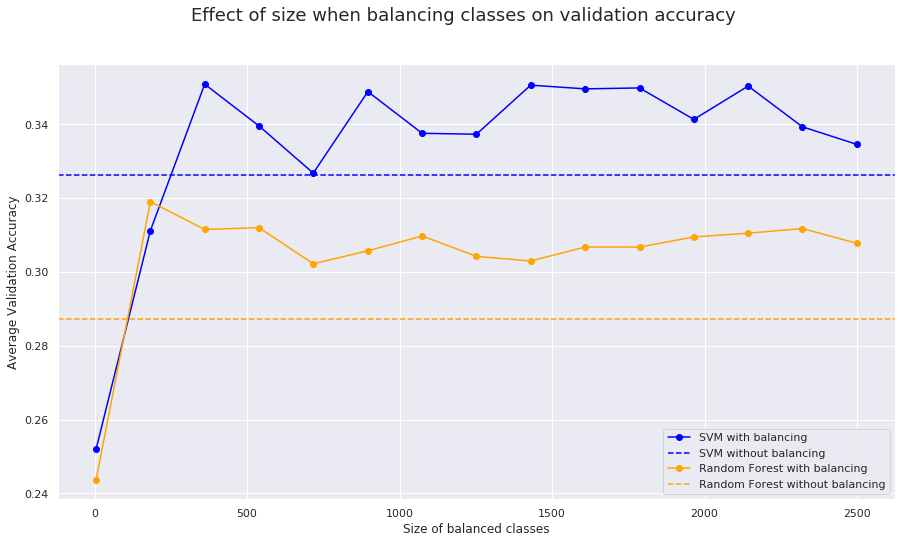

In [0]:
# Plot validation accuracy against class size for RF and SVM classifiers
fig, ax = plt.subplots(figsize=(15,8))

ax.plot(sizes[:-1], accuracy_val_svm[:-1], marker='o', color='blue', label='SVM with balancing')
ax.axhline(y=accuracy_val_svm[-1], linestyle='dashed', color='blue', label=f'SVM without balancing')
ax.plot(sizes[:-1], accuracy_val_rf[:-1], marker='o', color='orange', label='Random Forest with balancing')
ax.axhline(y=accuracy_val_rf[-1], linestyle='dashed', color='orange', label=f'Random Forest without balancing')

fig.suptitle('Effect of size when balancing classes on validation accuracy', fontsize=18)
ax.set_xlabel('Size of balanced classes')
ax.set_ylabel('Average Validation Accuracy')
ax.legend()
plt.show()

From the graph, it can be seen that balancing the dataset (within cross-validation) increases the average validation accuracy for both the default RF and SVM classifiers. Furthermore, there does not seem to be any clear trend for how the size of the class does affects the accuracy in the range 500-2500. The size of the balanced classes is therefore set to near middle of this range (1400), which is also about the size of the biggest class, for the rest of the analysis. A function is written in order to balance the data more succinctly:

In [0]:
def balance_data(X_train, y_train, size=1400):
    # Combine X_train and y_train
    train_temp = X_train.join(y_train, how='outer')

    # Divide by class
    class_range = range(1, 5) if y_train.min() == 1 else range(0, 4) # For neural network classes
    train_classes = [train_temp[train_temp['rating'] == i] for i in class_range]
    min_size = min([len(i) for i in train_classes])
    max_size = max([len(i) for i in train_classes])

    train_classes_bal = []
    for train_class in train_classes:
        if size > len(train_class):
            # Oversample with replacement
            replace = True
        else:
            # Undersample without replacement
            replace = False

        # Balance classes
        # Set random state for reproducibility of results
        train_classes_bal.append(train_class.sample(size, replace=replace, random_state=42).reset_index().drop(columns=['index']))
        train_balanced = pd.concat([i for i in train_classes_bal])

    # Split into X_train and y_train
    X_train = train_balanced[predictors]
    y_train = train_balanced['rating']

    return X_train, y_train

# Data Standardisation


- The descriptors are now standardised so that they have a mean of 0 and standard deviation of 1. It is important to do this, since if the descriptors are not standardized, the fit might depend on the scale of all the predictors. For example, **if we were to apply an L2 regularization of our parameters, then clearly the parameters that vary over larger scales will be penalized the most** since they take on larger values on average. This means that the model is **not invariant to the scale of the predictor variables**, which in general is not desired. Another small advantage is that the fitted parameters of the standardised descriptors might be more interpretable since they are all on the same scale.

- Also, there might be other scenarios where algorithms are designed to handle standardised data. For example, some algorithms might **take a very long time to converge** if the scales of the predictors are very different. If two predictors have very different ranges, the learning algorithm will likely be oscillating in the flat region of the loss landscape before finding a minimum, since its movement does not take into account the scale of the predictors, and will move too much in the plane of the predictor with the smaller scale, and tool little in the plane of the predictor with the larger scale.

## Standardisation with Cross-Validation
- As with balancing, it is important to consider is whether to standardize descriptors **before or after cross-validation**. Since cross-validation is used to estimate the performance of a particular statistical procedure, the standardisation should be repeated every time (instead of just once at the beginning with the standardization scaler being fit on the whole training set), since this standardisation procedure is part of the statistical model. If this is not done, then there is some **bias introduced into the model** (since information about the **whole** training set has been leaked into the cross-validation training set), which could lead to worse results for the final model. Therefore the standardisation procedure will be repeated every time, fitted on the training set for each individual cross validation. **I have included a commented version of how I standardize the data for convenience:**

In [0]:
# Define the standardisation scalers used for all transformations
Xscaler = sklearn.preprocessing.StandardScaler()

'''Commented version of standardising the data. (See commentary above)
Inside cross-validation, the standard scaler is fit only on the training data, which 
is then used to transform both the training data and the validation data:
'''
# Xscaler.fit(X_train)
# X_train_scaled = Xscaler.transform(X_train)
# X_val_scaled = Xscaler.transform(X_val)

'Commented version of standardising the data. (See commentary above)\nInside cross-validation, the standard scaler is fit only on the training data, which \nis then used to transform both the training data and the validation data:\n'

# Cross-Validation
Cross-Validation is a robust technique that helps to increase the stability and generalizability of models. It helps to reduce model variance by splitting the training data up into k subsets, and then trains on k-1 subsets, evaluating the model on the remaining subset. The score across all folds then provides a more accurate measure of how the model would perform on unseen data, which in turn reduces the tendency for the model to overfit.
- The validation set for each of the k folds is achieved through **stratified random sampling**. This involves splitting the training data into strata and sampling within these strata in order to achieve similar distributions between the training and validation sets. This ensures that the validation data is representative of the training data, which means that metrics derived from this validation data are more reliable.

# Random Forest Classifier
A random forest classifier will now be trained on the training set to optimise for **accuracy**, using 5-fold stratified cross-validation to tune hyperparameters. As stated in the question, other metrics such as precision and recall could be used as well, but for simplicity only accuracy is considered.

#Hyperparameter Tuning
This is a multi-dimensional problem and would take a long time to compute the optimal params in this multi-dimensional space. In order to overcome this, I do an initial search over this space to get a rough estimate of good parameters to choose. These params are then fixed to this selection, and each one is varied individually, so that the computational time required is massively reduced, and that these parameters would hopefully be close to solutions acquired after a full search of the multi-dimensional space.
- The hope is that this method finds a parameter combination that is both stable (insensitive to small adjustments of the parameters), and computationally feasible. This method provides stability by analysing individual parameters with multiple fixed models to make sure that correlations between predictors are accounted for. This is important to visualize so that a model that is unstable is not chosen.

- For example, a model with a small number of trees, small depth and small number of predictors chosen at each split could have the best average validation accuracy. However, this model would be expected to be unstable since it is so small, and correlations between predictors at this small range are high; this is illustrated in the figures throughout this analysis.

In [138]:
# Generate wide range of hyperparameters for number of decision trees, depth of trees
# and maximum number of descriptors randomly chosen at each split
tree_nums = np.logspace(0, 2.5, 8, dtype=int)
tree_depths = np.logspace(0, 1.2, 8, dtype=int)
predictor_nums = range(1, len(predictors)+1)

# Perform a quick initial search over 3-dimensional parameter space in order to 
# locate a rough range of optimal values for each parameter
folds = 5
max_accuracy = 0
for tree_num in tree_nums:
    print(f'Training for number of trees = {tree_num}')
    for tree_depth in tree_depths:
        for predictor_num in predictor_nums:

            # Generate splits for 5-fold stratified cross-validation
            # Fix random_state for reproducible results
            skf = StratifiedKFold(n_splits=folds, random_state=42, shuffle=True)

            # Train a Random Forest for each split
            accuracy_list = []
            for train_index, val_index in skf.split(X_train_full, y_train_full):
                X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
                y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]

                # Balance training set inside fold
                X_train, y_train = balance_data(X_train, y_train)

                # Fit standardisation scalers to training set for the cross-validation split
                # for each model during cross-validation
                Xscaler.fit(X_train)

                # Transform training and valiadtion data using the scaler that was fit on 
                # the training data for the cross-validation split
                X_train_scaled = Xscaler.transform(X_train)
                X_val_scaled = Xscaler.transform(X_val)
                
                # Initialize the random forest and train
                clf = RandomForestClassifier(n_estimators=tree_num, max_depth=tree_depth, criterion="gini",\
                    random_state=42, max_features=predictor_num, bootstrap=True, oob_score=True, n_jobs=-1)
                clf.fit(X_train_scaled, y_train)

                # Compute accuracy and add to list
                accuracy_list.append(clf.score(X_val_scaled, y_val))

            # Compute average validation accuracy across the 5 folds for this choice of parameters
            accuracy = np.mean(accuracy_list)

            # Update optimal parameters if accuracy is highermore
            if accuracy > max_accuracy:
                max_accuracy = accuracy
                tree_num_best, tree_depth_best, predictor_num_best = [tree_num, tree_depth, predictor_num]


Training for number of trees = 1
Training for number of trees = 2
Training for number of trees = 5
Training for number of trees = 11
Training for number of trees = 26
Training for number of trees = 61
Training for number of trees = 138
Training for number of trees = 316


In [139]:
# Report optimal parameters from this quick initial search
df_table = pd.DataFrame(columns=['Initial Tuned Hyperparameters', 'Number of Trees', 'Depth of Trees', 'Number or Predictors', 'Average Validation Accuracy'])
df_table.loc[0] = ['-', tree_num_best, tree_depth_best, predictor_num_best, round(max_accuracy, 3)]
df_table

,Initial Tuned Hyperparameters,Number of Trees,Depth of Trees,Number or Predictors,Average Validation Accuracy
0,-,316,4,2,0.391


A function is written to evaluate models with a given range of parameters (for the 3 parameters in the question) in order to avoid repeated blocks of code:

In [0]:
def eval_RF(tree_nums, tree_depths, predictor_nums):
    '''
    Evaluates RF for given lists of parameters (must be lists of the same length)
    Outputs training and validation accuracy, averaged across k folds
    '''
    # Get length of the lists (arguments are allowed to be integers)
    for param in tree_nums, tree_depths, predictor_nums:
        try:
            length = len(param)
        except TypeError:
            pass

    # Transfrom integer parameters into lists
    if isinstance(tree_nums, (int, np.int64)):
        tree_nums = [tree_nums] * length
    if isinstance(tree_depths, (int, np.int64)):
        tree_depths = [tree_depths] * length
    if isinstance(predictor_nums, (int, np.int64)):
        predictor_nums = [predictor_nums] * length
    
    accuracy_train = []
    accuracy_val = []

    for i in range(len(tree_nums)):
        tree_num = tree_nums[i]
        tree_depth = tree_depths[i]
        predictor_num = predictor_nums[i]

        # Initialize the random forest
        clf = RandomForestClassifier(n_estimators=tree_num, max_depth=tree_depth, criterion="gini",\
            random_state=42, max_features=predictor_num, bootstrap=True, oob_score=True, n_jobs=-1)

        # Train a Random Forest for each split
        accuracy_list_train = []
        accuracy_list_val = []
        for train_index, val_index in skf.split(X_train_full, y_train_full):
            X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
            y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]

            # Balance training set inside fold
            X_train, y_train = balance_data(X_train, y_train)

            # Fit standardisation scalers to training set for the cross-validation split
            # for each model during cross-validation
            Xscaler.fit(X_train)

            # Transform training and valiadtion data using the scaler that was fit on 
            # the training data for the cross-validation split
            X_train_scaled = Xscaler.transform(X_train)
            X_val_scaled = Xscaler.transform(X_val)
            
            # Fit the random forest to the training set
            clf.fit(X_train_scaled, y_train)

            # Compute accuracy and add to list
            accuracy_list_train.append(clf.score(X_train_scaled, y_train))
            accuracy_list_val.append(clf.score(X_val_scaled, y_val))

        # Compute average training and validation accuracy
        accuracy_train.append(np.mean(accuracy_list_train))
        accuracy_val.append(np.mean(accuracy_list_val))

    return accuracy_train, accuracy_val

# Number of Trees
Decision trees by themselves tend to overfit, which leads to them not being very generalisable. The trees are therefore bootstrapped and aggregated (bagging) to produce a random forest.

## Decision Trees and Bagging
 A method called bagging (bootstrap aggregation) is implemented to improve on decision trees, which introduces some randomness into many trees and combines the trees at the end into a random forest. Bootstrapping is applied in order to reduce the variance of the random forest since the bootstrapped trees are then quite uncorrelated with eachother, which in turn reduces the tendency to overfit and therefore increases generalisability.

The number of trees is then investigated using the function created above, using the roughly tuned parameters for tree depth and predictor number as constant parameters throughout.

In [0]:
# Generate list of number of trees for which to test models for
tree_nums = np.linspace(2, 250, 25, dtype=int)

accuracy_vals = []
accuracy_trains = []

# Evaluate best number of trees using best values for tree depth and number of parameters at each split
_, accuracy_val = eval_RF(tree_nums, tree_depth_best, predictor_num_best)
accuracy_vals.append(accuracy_val)

# Evaluate best number of trees for 2 other tree depths
_, accuracy_val = eval_RF(tree_nums, tree_depth_best//2, predictor_num_best)
accuracy_vals.append(accuracy_val)
_, accuracy_val = eval_RF(tree_nums, tree_depth_best*2, predictor_num_best)
accuracy_vals.append(accuracy_val)

# Evaluate best number of trees for 2 other number of parameters at each split
_, accuracy_val = eval_RF(tree_nums, tree_depth_best, 1)
accuracy_vals.append(accuracy_val)
_, accuracy_val = eval_RF(tree_nums, tree_depth_best, predictor_num_best+2)
accuracy_vals.append(accuracy_val)

### Setting the best parameter for number of trees
The accuracy for varying numbers of trees was evaluated for 3 fixed depths of trees, and 3 fixed number of parameters at each split. 

I will set the number of trees to be the value at which the average of the validation accuracy across all 5 of the models is highest. This should give a more robust estimate for the optimal number compared to just taking the best number of trees found with one value for the depth of trees and number of parameters at each split. This is because there is some dependance between these predictors and they will be more finely tuned towards the end.

In [144]:
tree_num_best = tree_nums[np.argmax([sum(x) for x in zip(*accuracy_vals)])]
print(f'Optimal number of trees: {tree_num_best}')

Optimal number of trees: 177


The average validation accuracies are plotted for different values of tree depth and number of predictors chosen at each split, in order to visualize any dependancies between theses parameters that may affect the optimal parameter combination.

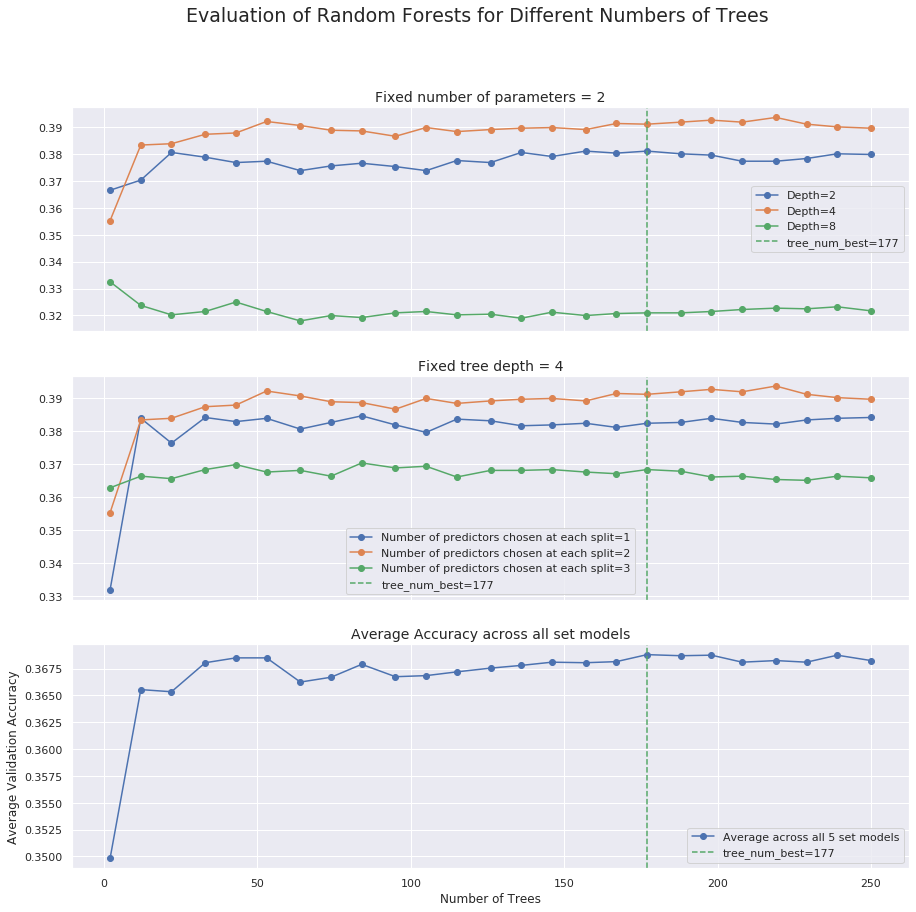

In [145]:
# Plot average validation accuracy against number of trees
fig, axes = plt.subplots(3, 1, figsize=(15,14), sharex=True)

# Plot first graph with different tree depths
axes[0].plot(tree_nums, accuracy_vals[1], marker='o', label=f'Depth={tree_depth_best//2}')
axes[0].plot(tree_nums, accuracy_vals[0], marker='o', label=f'Depth={tree_depth_best}')
axes[0].plot(tree_nums, accuracy_vals[2], marker='o', label=f'Depth={tree_depth_best*2}')
axes[0].set_title(f'Fixed number of parameters = {predictor_num_best}', fontsize=14)

# Plot second graph with different number of parameters at each split
axes[1].plot(tree_nums, accuracy_vals[3], marker='o', label=f'Number of predictors chosen at each split=1')
axes[1].plot(tree_nums, accuracy_vals[0], marker='o', label=f'Number of predictors chosen at each split={predictor_num_best}')
axes[1].plot(tree_nums, accuracy_vals[4], marker='o', label=f'Number of predictors chosen at each split={predictor_num_best+1}')
axes[1].set_title(f'Fixed tree depth = {tree_depth_best}', fontsize=14)

# Plot average accuracy used as metric to find initial best number of trees
axes[2].plot(tree_nums, [sum(x)/5 for x in zip(*accuracy_vals)], marker='o', label='Average across all 5 set models')
axes[2].set_title(f'Average Accuracy across all set models', fontsize=14)

for ax in axes:
    ax.axvline(x=tree_num_best, linestyle='dashed', color='g', label=f'tree_num_best={tree_num_best}')
    ax.legend()
fig.suptitle('Evaluation of Random Forests for Different Numbers of Trees', fontsize=19)
plt.xlabel('Number of Trees')
plt.ylabel('Average Validation Accuracy')
plt.show()

As the number of trees increases, the average validation accuracy increases, but only by a little when the number of trees is high. This is expected since an extra tree just adds another estimate of the model, which would increase the forest only slightly. 
- The maximum of the third graph displaying the average accuracy across the 5 models that were used is used to find the initial best number of trees. This will be repeated for the other two hyperparameters, then a more fine-tuned search around the initial best values will be performed at the end.


# Tree Depth
The optimum depth of trees is now explored. If a tree is allowed to grow very deep, it is likely to overfit (this will be illustrated below). The best depth of trees is now explored using the same procedure as before.

In [0]:
# Generate list of depth of trees for which to test models for
tree_depths = np.linspace(1, 25, 8, dtype=int)

accuracy_vals = []
accuracy_trains = []

# Evaluate best depth of trees using best values for tree depth and number of parameters at each split
accuracy_train, accuracy_val = eval_RF(tree_num_best, tree_depths, predictor_num_best)
accuracy_trains.append(accuracy_train)
accuracy_vals.append(accuracy_val)

# Evaluate best depth of trees for 2 other tree numbers
accuracy_train, accuracy_val = eval_RF(tree_num_best//2, tree_depths, predictor_num_best)
accuracy_trains.append(accuracy_train)
accuracy_vals.append(accuracy_val)

accuracy_train, accuracy_val = eval_RF(tree_num_best*2, tree_depths, predictor_num_best)
accuracy_trains.append(accuracy_train)
accuracy_vals.append(accuracy_val)

# Evaluate best depth of trees for 2 other number of parameters at each split
accuracy_train, accuracy_val = eval_RF(tree_num_best, tree_depths, 1)
accuracy_trains.append(accuracy_train)
accuracy_vals.append(accuracy_val)

accuracy_train, accuracy_val = eval_RF(tree_num_best, tree_depths, predictor_num_best+2)
accuracy_trains.append(accuracy_train)
accuracy_vals.append(accuracy_val)

In [154]:
tree_depth_best = 4  # Set from graph
print(f'Optimal depth of trees: {tree_depth_best}')

Optimal depth of trees: 4


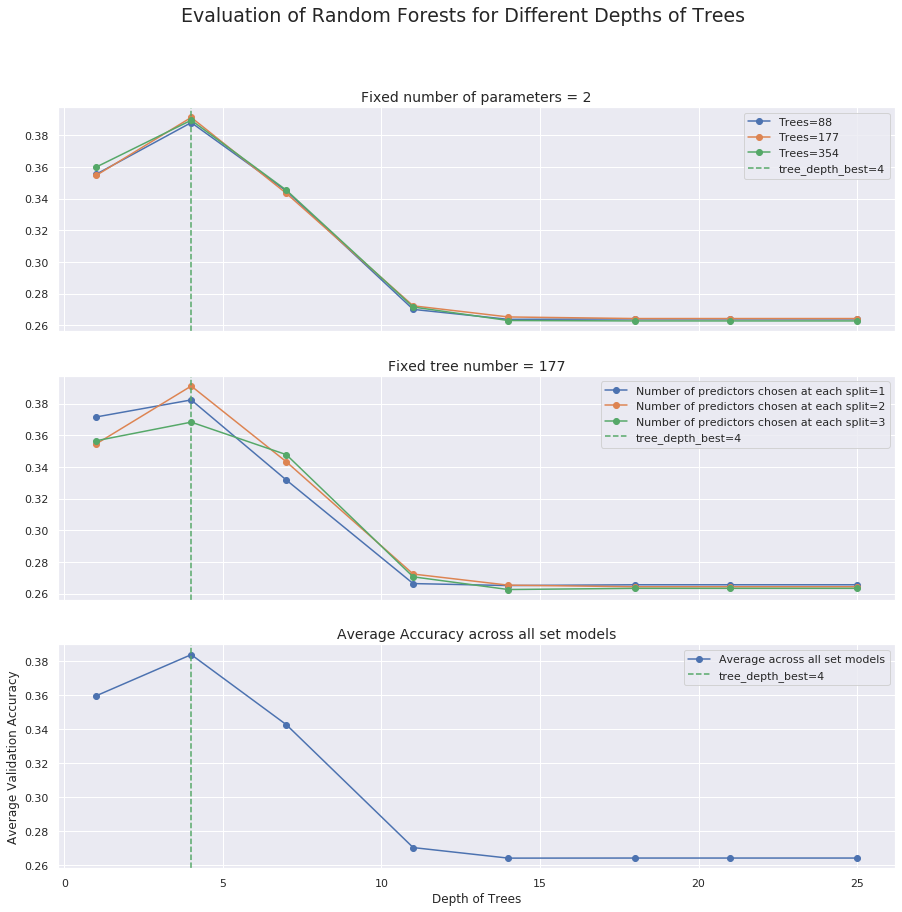

In [155]:
# Plot average validation accuracy against depth of trees
fig, axes = plt.subplots(3, 1, figsize=(15,14), sharex=True)

# Plot first graph with different tree depths
axes[0].plot(tree_depths, accuracy_vals[1], marker='o', label=f'Trees={tree_num_best//2}')
axes[0].plot(tree_depths, accuracy_vals[0], marker='o', label=f'Trees={tree_num_best}')
axes[0].plot(tree_depths, accuracy_vals[2], marker='o', label=f'Trees={tree_num_best*2}')
axes[0].set_title(f'Fixed number of parameters = {predictor_num_best}', fontsize=14)

# Plot second graph with different number of parameters at each split
axes[1].plot(tree_depths, accuracy_vals[3], marker='o', label=f'Number of predictors chosen at each split=1')
axes[1].plot(tree_depths, accuracy_vals[0], marker='o', label=f'Number of predictors chosen at each split={predictor_num_best}')
axes[1].plot(tree_depths, accuracy_vals[4], marker='o', label=f'Number of predictors chosen at each split={predictor_num_best+1}')
axes[1].set_title(f'Fixed tree number = {tree_num_best}', fontsize=14)

# Plot average accuracy used as metric to find initial best depth of trees
axes[2].plot(tree_depths, [sum(x)/5 for x in zip(*accuracy_vals)], marker='o', label='Average across all set models')
axes[2].set_title(f'Average Accuracy across all set models', fontsize=14)

for ax in axes:
    ax.axvline(x=tree_depth_best, linestyle='dashed', color='g', label=f'tree_depth_best={tree_depth_best}')
    ax.legend()

fig.suptitle('Evaluation of Random Forests for Different Depths of Trees', fontsize=19)
plt.xlabel('Depth of Trees')
plt.ylabel('Average Validation Accuracy')
plt.show()

We expect that if the depth of the trees is large, then each tree is allowed more and more splits in order to better describe the data from the predictors. It this is done too much, the model will tend to overfit. The graph below illustrates this:

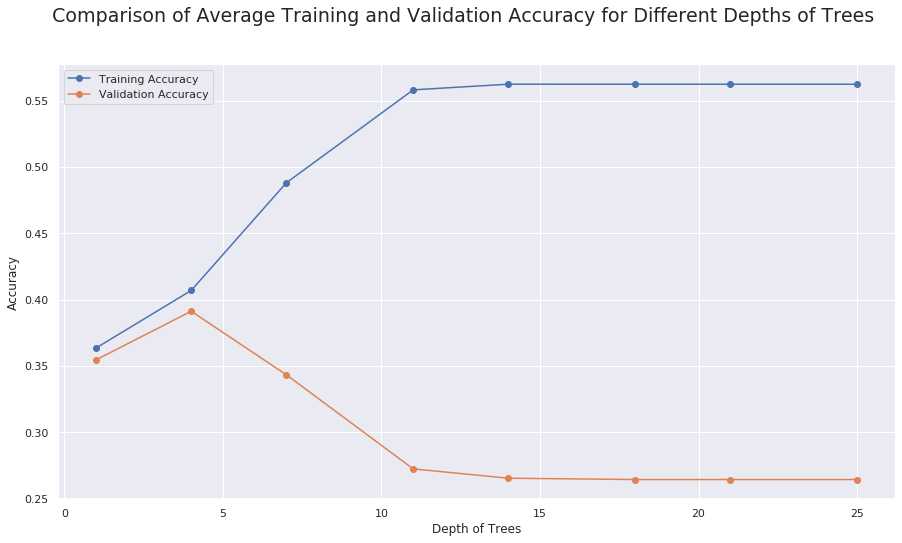

In [156]:
# Plot average training and validation accuracy against depth of trees
fig, ax = plt.subplots(1, 1, figsize=(15,8))

# Plot graph with different tree depths
ax.plot(tree_depths, accuracy_trains[0], marker='o', label=f'Training Accuracy')
ax.plot(tree_depths, accuracy_vals[0], marker='o', label=f'Validation Accuracy')
ax.legend()

fig.suptitle('Comparison of Average Training and Validation Accuracy for Different Depths of Trees', fontsize=19)
plt.xlabel('Depth of Trees')
plt.ylabel('Accuracy')
plt.show()

- The above figure illustrates how each tree can make more decisions in order to better classify the data, leading to an increasing plot of training accuracy against tree depth up to a point. The training accuracy levels off since the trees can no longer make any splits that better clasify the data.
- The validation accuracy increases at a peak of around depth=4, and decreases as the depth increases past 4, since the model is overfitting and doesn't generalize well to unseen data.

# Number of predictors randomly selected at each split
- At each split for each tree in the random forest, the model randomly selects n out of all of the predictors. The model can then only made splits using these features. This acts as regularisation, since it stops individual predictors becoming too heavily weighted. 

- If the number of predictors selected at each split is small, your decision trees will be very different, since the number predictors to choose from at each split is small, so the decisions at each split is likely to be different each time.

In [0]:
# Generate list of number of parameters at each split for which to test models for
predictor_nums = range(1, len(predictors)+1)

accuracy_vals = []
accuracy_trains = []

# Evaluate best depth of trees using best values for tree depth and number of parameters at each split
accuracy_train, accuracy_val = eval_RF(tree_num_best, tree_depth_best, predictor_nums)
accuracy_trains.append(accuracy_train)
accuracy_vals.append(accuracy_val)

# Evaluate best depth of trees for 2 other tree numbers
accuracy_train, accuracy_val = eval_RF(tree_num_best//2, tree_depth_best, predictor_nums)
accuracy_trains.append(accuracy_train)
accuracy_vals.append(accuracy_val)

accuracy_train, accuracy_val = eval_RF(tree_num_best*2, tree_depth_best, predictor_nums)
accuracy_trains.append(accuracy_train)
accuracy_vals.append(accuracy_val)

# Evaluate best depth of trees for 2 other number of parameters at each split
accuracy_train, accuracy_val = eval_RF(tree_num_best, tree_depth_best//2, predictor_nums)
accuracy_trains.append(accuracy_train)
accuracy_vals.append(accuracy_val)

accuracy_train, accuracy_val = eval_RF(tree_num_best, tree_depth_best*2, predictor_nums)
accuracy_trains.append(accuracy_train)
accuracy_vals.append(accuracy_val)

In [159]:
predictor_num_best = predictor_nums[np.argmax([sum(x) for x in zip(*accuracy_vals)])]
# predictor_num_best = 2
print(f'Optimal number of predictors chosen at each split: {predictor_num_best}')

Optimal number of predictors chosen at each split: 2


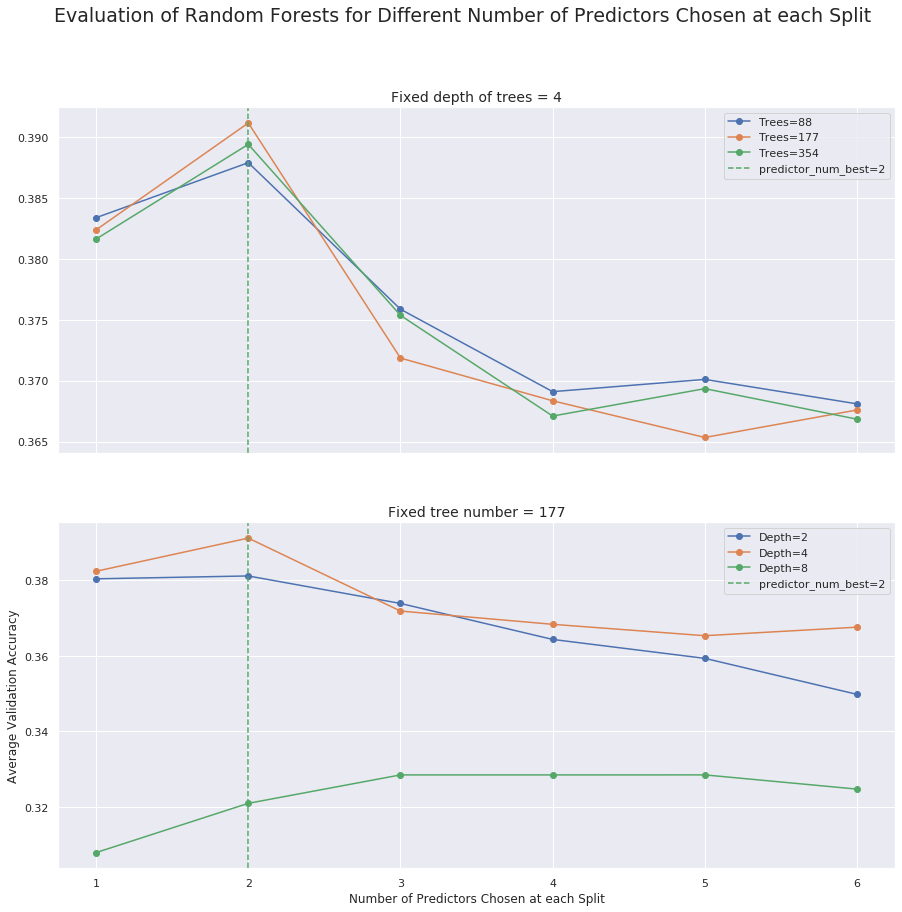

In [160]:
# Plot average validation accuracy against number of predictors chosen at each split
fig, axes = plt.subplots(2, 1, figsize=(15,14), sharex=True)

# Plot first graph with different tree depths
axes[0].plot(predictor_nums, accuracy_vals[1], marker='o', label=f'Trees={tree_num_best//2}')
axes[0].plot(predictor_nums, accuracy_vals[0], marker='o', label=f'Trees={tree_num_best}')
axes[0].plot(predictor_nums, accuracy_vals[2], marker='o', label=f'Trees={tree_num_best*2}')
axes[0].set_title(f'Fixed depth of trees = {tree_depth_best}', fontsize=14)

# Plot second graph with different number of parameters at each split
axes[1].plot(predictor_nums, accuracy_vals[3], marker='o', label=f'Depth={tree_depth_best//2}')
axes[1].plot(predictor_nums, accuracy_vals[0], marker='o', label=f'Depth={tree_depth_best}')
axes[1].plot(predictor_nums, accuracy_vals[4], marker='o', label=f'Depth={tree_depth_best*2}')
axes[1].set_title(f'Fixed tree number = {tree_num_best}', fontsize=14)

for ax in axes:
    ax.axvline(x=predictor_num_best, linestyle='dashed', color='g', label=f'predictor_num_best={predictor_num_best}')
    ax.legend()

fig.suptitle('Evaluation of Random Forests for Different Number of Predictors Chosen at each Split', fontsize=19)
plt.xlabel('Number of Predictors Chosen at each Split')
plt.ylabel('Average Validation Accuracy')
plt.show()

- The tuned value for the number of predictors chosen at each split is 2. This is consistent with the value recommended in literature (n_predictors/3 = 2), which gives us confidence that our model is reasonable.

A final search of the full param space is performed in order to account for the correlations between hyperparameters, which means that the individually tuned parameters that were found might not necessarily (and probably are not) the best parameters to maximise average validation accuracy. Ideally this search would run on bigger lists of parameters but in the interest of lower computation time, only small lists are used.

In [162]:
# Generate list of params for a final 3D sweep of parameter space
tree_nums = np.linspace(tree_num_best-4, tree_num_best+4, 3, dtype=int)
tree_depths = np.linspace(1, tree_depth_best+3, tree_depth_best+3, dtype=int)
predictor_nums = np.linspace(1, predictor_num_best+1, predictor_num_best+1, dtype=int)

# Evaluate RF classifier for every combination
params = []
max_accuracy = 0
for tree_num in tree_nums:
    for tree_depth in tree_depths:
        _, accuracy_vals = eval_RF(tree_num, tree_depth, predictor_nums)

        # Find best model for this combination of parameters
        predictor_num = predictor_nums[np.argmax(accuracy_vals)]

        # Replace best parameters if average validation accuracy is higher
        accuracy = np.max(accuracy_vals)
        if accuracy > max_accuracy:
            tree_num_best = tree_num
            tree_depth_best = tree_depth
            predictor_num_best = predictor_num
            max_accuracy = accuracy

# Report optimal parameters from final search
df_table = pd.DataFrame(columns=['Tuned Hyperparameters', 'Number of Trees', 'Depth of Trees', 'Number or Predictors', 'Average Validation Accuracy'])
df_table.loc[0] = ['-', tree_num_best, tree_depth_best, predictor_num_best, round(max_accuracy, 3)]
df_table


,Tuned Hyperparameters,Number of Trees,Depth of Trees,Number or Predictors,Average Validation Accuracy
0,-,169,4,2,0.392


# Summary of RF model
- From the analysis above, it can be seen firstly that the number of trees doesn't impact the performance of the models much - increasing the number of trees slightly increases the model accuracy but also adds some computation time. However this increase gets very small, and so it would not be computationally feasible to increase the number of trees significantly.
- The depth of trees is clearly significant from the plots, and has a clear peak in validation accuracy, since a low depth has little descriptive power (the trees are not making many decisions), and a high depth means that the trees greatly overfit, as shown in the low validation accuracy.
- The number of predictors is also an important parameter, and controls for single parameters becoming too predictive in the model. A value of 2 for this parameter was found, and helps to reduce the variance of the models, since the trees are less correlated and the random forest is then more generalizable.

# SVM
A function is written first in order to evaluate the average training and validation accuracy for an SVM with different parameters. An SVM aims to fit decision boundaries in high dimensional space in order to separate classes. This can be done with different kernels, making the SVM a very flexible model.


In [0]:
def eval_SVM(C, kernel, X_train_full=X_train_full, y_train_full=y_train_full,degree=3, gamma='auto'):
    # Train a SVM using the training data
    accuracy_train = []
    accuracy_val = []

    # Set up the SVM
    clf = svm.SVC(C=C, kernel=kernel, degree=degree, gamma=gamma)

    # Use stratified 5-fold cross-validation to evaluate models
    for train_index, val_index in skf.split(X_train_full, y_train_full):
        X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
        y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]

        # Balance training set inside fold
        X_train, y_train = balance_data(X_train, y_train)

        # Fit standardisation scalers to training set for the cross-validation split
        # for each model during cross-validation
        Xscaler.fit(X_train)

        # Transform training and valiadtion data using the using different kernels #READ DOCUMENTATION FOR EXTRA IDEAS scaler that was fit on 
        # the training data for the cross-validation split
        X_train_scaled = Xscaler.transform(X_train)
        X_val_scaled = Xscaler.transform(X_val)
        
        # Train SVMs
        clf.fit(X_train_scaled, y_train)

        # Compute accuracy and add to list
        accuracy_train.append(accuracy_score(clf.predict(X_train_scaled), y_train))
        accuracy_val.append(accuracy_score(clf.predict(X_val_scaled), y_val))

    # Return average training and validation accuracy
    return np.mean(accuracy_train), np.mean(accuracy_val)

# SVM Optimization
The hyperparameters for the SVM are now tuned. As with the ramdom forest, a rough search across the whole hyperparameter space is performed in order to get a feel for the rough scale of the optimal parameters. Then each hyperparameter will be tuned individually, and then a final search across the multi-dimensional hyperparameter space will decide the final hyperparameters.

# Kernels
---------

# Linear Kernel
The hyperparameters will be tuned individually for each different kernel (linear, polynomial and RBF). First the linear kernel SVM is optimized. The only hyperparameter tuned for the linear kernel will be C.

## Soft/Hard-Margin Constant C
The value of C affects the penalization of samples that are incorrectly classified. A small value of C will allow more errors, leading to larger margins. As C increases, the margin gets 'harder', and the penalty for incorrectly labled classes is increased. This leads to more complex models that may classify better but with the risk of overfitting. The average cross-validated accuracy is first roughly plotted:

In [0]:
# Train SVM with a linear kernel
C_list = np.logspace(-4, 1.5, 6)
kernel = 'linear'

accuracy_vals = []
accuracy_trains = []

for C in C_list:
    accuracy_train, accuracy_val = eval_SVM(C=C, kernel=kernel)
    accuracy_trains.append(accuracy_train)
    accuracy_vals.append(accuracy_val)

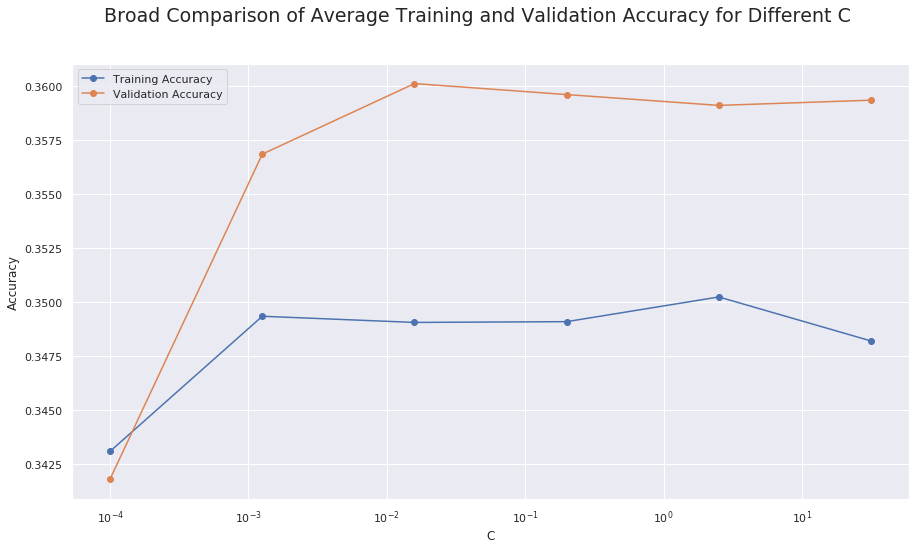

In [165]:
# Plot average training and validation accuracy against C
fig, ax = plt.subplots(1, 1, figsize=(15,8))

# Plot graph with different C
ax.semilogx(C_list, accuracy_trains, marker='o', label=f'Training Accuracy')
ax.semilogx(C_list, accuracy_vals, marker='o', label=f'Validation Accuracy')
ax.legend()

fig.suptitle('Broad Comparison of Average Training and Validation Accuracy for Different C', fontsize=19)
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.show()

- From the figure, as C increases, the validation accuracy is seen to increases and peak at somewhere around 0.1. The low validation accuracy when C is very low is due to the model underfitting, since the model hardly penalizes incorrectly classified samples (soft margin). 
- As C gets bigger (hard margin), the model tries to include more and more of the samples within the classifications, leading to overfitting as the penalty becomes harsher. This is seen in the figure: the training accuracy gets higher since it classifies more samples correctly, and the validation accuracy gets lower since the model is overfitting. Another more detailed search is performed for the area around 0.1:

In [0]:
# Train SVM with a linear kernel
C_list = np.logspace(-2, 0.5, 25)
kernel = 'linear'

accuracy_vals = []
accuracy_trains = []

for C in C_list:
    print(C)
    accuracy_train, accuracy_val = eval_SVM(C=C, kernel=kernel)
    accuracy_trains.append(accuracy_train)
    accuracy_vals.append(accuracy_val)

# Compute optimal value for C
linear_C_best = C_list[np.argmax(accuracy_vals)]

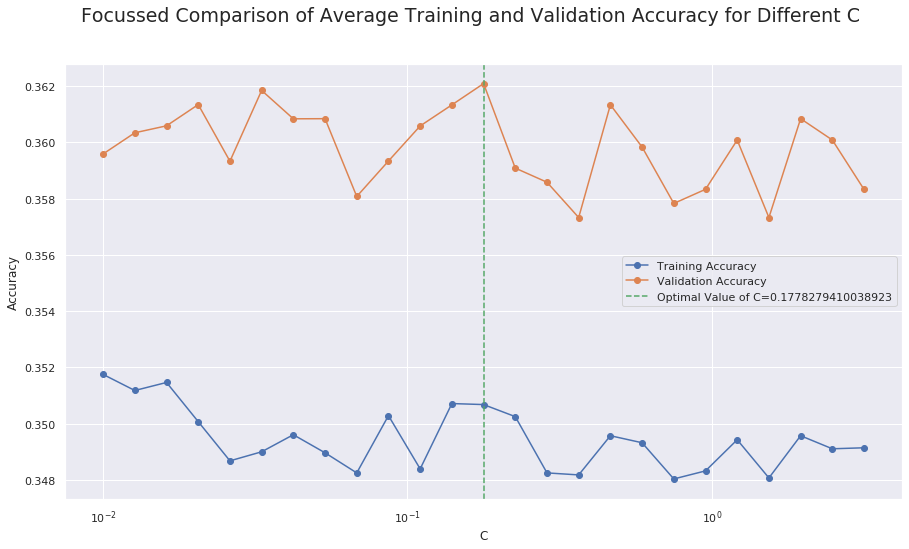

In [0]:
# Plot average training and validation accuracy against C
fig, ax = plt.subplots(1, 1, figsize=(15,8))

# Plot graph with different C
ax.semilogx(C_list, accuracy_trains, marker='o', label=f'Training Accuracy')
ax.semilogx(C_list, accuracy_vals, marker='o', label=f'Validation Accuracy')
ax.axvline(x=linear_C_best, label=f'Optimal Value of C={linear_C_best}', color='g', linestyle='dashed')
ax.legend()

fig.suptitle('Focussed Comparison of Average Training and Validation Accuracy for Different C', fontsize=19)
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.show()

The optimal value of C is chosen to be the value which maximises the average validation accuracy. There is no clear optimal value of C in this range so it won't affect the model much as long as we pick C in the plotted range.

# Polynomial Kernel
The linear kernel is not sufficient when there exists some non-linear relationships between predictors. Higher degree polynomials kernels allow for more flexibility and so increases model complexity, which can describe the data better, with the risk of overfitting.


## Degree parameter
The degree parameter is only valid when the kernel is polynomial, and controls the maximum degree of the fitted polynomial.


## Gamma parameter
- Gamma controls for how tightly the model fits to the samples. A low value of gamma tends to underfit samples as it covers too broad an area. 
- A higher value of gamma leads to overfitting as the boundaries are fit too close to the samples, leading to a bad generalization of the boundaries.

- The parameter space for the polynomial kernel SVM is now explored. Again, ideally a larger parameter spaced would be searched, however limited computational time and power limits the size of this search:

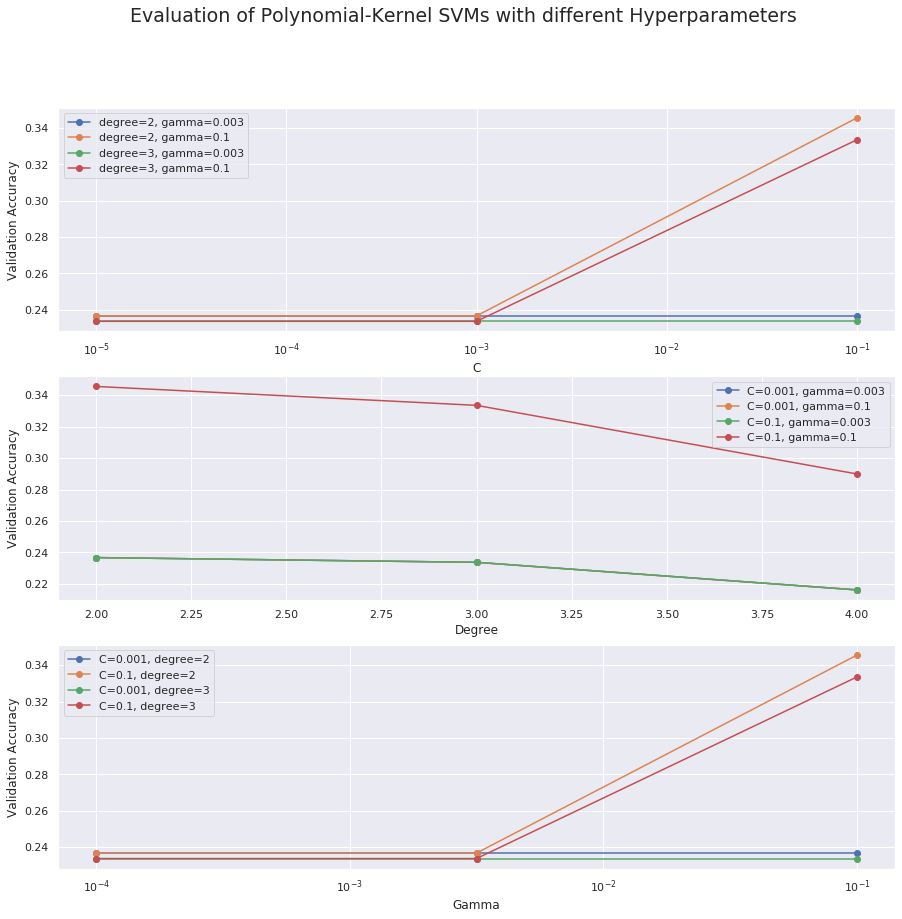

In [173]:
# Plot average validation accuracy against hyperparameters
fig, axes = plt.subplots(3, 1, figsize=(15,14))

# Plot first graph, varying C
axes[0].semilogx(C_list, accuracy_vals[:, 0, 1], marker='o', label=f'degree={degrees[0]}, gamma={round(gammas[1], 3)}')
axes[0].semilogx(C_list, accuracy_vals[:, 0, 2], marker='o', label=f'degree={degrees[0]}, gamma={round(gammas[2], 3)}')
axes[0].semilogx(C_list, accuracy_vals[:, 1, 1], marker='o', label=f'degree={degrees[1]}, gamma={round(gammas[1], 3)}')
axes[0].semilogx(C_list, accuracy_vals[:, 1, 2], marker='o', label=f'degree={degrees[1]}, gamma={round(gammas[2], 3)}')
axes[0].set_xlabel('C')

# Plot second graph, varying degree
axes[1].plot(degrees, accuracy_vals[1, :, 1], marker='o', label=f'C={round(C_list[1], 3)}, gamma={round(gammas[1], 3)}')
axes[1].plot(degrees, accuracy_vals[1, :, 2], marker='o', label=f'C={round(C_list[1], 3)}, gamma={round(gammas[2], 3)}')
axes[1].plot(degrees, accuracy_vals[2, :, 1], marker='o', label=f'C={round(C_list[2], 3)}, gamma={round(gammas[1], 3)}')
axes[1].plot(degrees, accuracy_vals[2, :, 2], marker='o', label=f'C={round(C_list[2], 3)}, gamma={round(gammas[2], 3)}')
axes[1].set_xlabel('Degree')

# Plot first graph, varying gamma
axes[2].semilogx(gammas, accuracy_vals[1, 0, :], marker='o', label=f'C={round(C_list[1], 3)}, degree={degrees[0]}')
axes[2].semilogx(gammas, accuracy_vals[2, 0, :], marker='o', label=f'C={round(C_list[2], 3)}, degree={degrees[0]}')
axes[2].semilogx(gammas, accuracy_vals[1, 1, :], marker='o', label=f'C={round(C_list[1], 3)}, degree={degrees[1]}')
axes[2].semilogx(gammas, accuracy_vals[2, 1, :], marker='o', label=f'C={round(C_list[2], 3)}, degree={degrees[1]}')
axes[2].set_xlabel('Gamma')

for ax in axes:
    ax.legend()
    ax.set_ylabel('Validation Accuracy')

fig.suptitle('Evaluation of Polynomial-Kernel SVMs with different Hyperparameters', fontsize=19)
plt.show()

- The Polynomial kernel SVM performs slightly worse than the linear kernel (it is more flexible than the linear kernel so it can describe the data better, however in this case it has likely led to overfitting). This suggests than linear dependancies between predictors are sufficient to describe the relationships and be able to classify well.

# RBF Kernel
- The rbf kernel allows the boundaries to be flexible in the way it classifies data that the linear and polynomial kernels are unable to do. For example, the kernel could relate to the distance from a certain point, such that if some classes surround another class in n-dimensional space, the rbf kernel is able to better separate these classes (more than a linear/polynomial kernel). The model will be tuned with respect to C and Gamma:


In [0]:
# Train SVM with rbf kernel
C_list = np.logspace(-4, 0, 7)
gammas =  np.logspace(-4, 0, 7)
kernel = 'rbf'

# Use numpy ndarrays to store model evaluations
accuracy_vals = np.zeros((len(C_list), len(gammas)))
accuracy_trains = np.zeros((len(C_list), len(gammas)))

max_accuracy = 0
for i, C in enumerate(C_list):
    for j, gamma in enumerate(gammas):
        print(C, gamma)
        accuracy_trains[i,j], accuracy_vals[i,j] = eval_SVM(C=C, kernel=kernel, gamma=gamma)
        if accuracy_vals[i,j] > max_accuracy:
            rbf_C_best = C
            rbf_gamma_best = gamma
            max_accuracy = accuracy_vals[i,j]

# Report tuned hyperparameters
print("Tuned hyperparameters:")
print(f'C: {rbf_C_best}')
print(f'gamma: {rbf_gamma_best}')

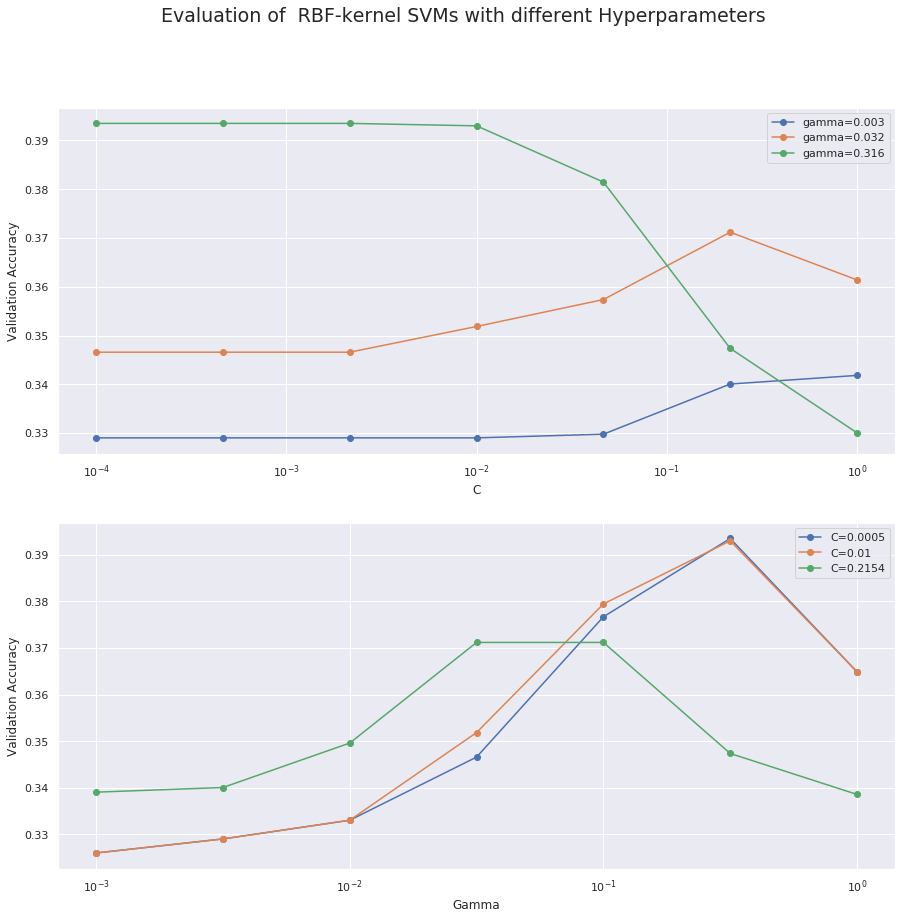

In [0]:
# Plot average validation accuracy against hyperparameters
fig, axes = plt.subplots(2, 1, figsize=(15,14))

# Plot first graph, varying C
axes[0].semilogx(C_list, accuracy_vals[:, 1], marker='o', label=f'gamma={round(gammas[1], 3)}')
axes[0].semilogx(C_list, accuracy_vals[:, 3], marker='o', label=f'gamma={round(gammas[3], 3)}')
axes[0].semilogx(C_list, accuracy_vals[:, 5], marker='o', label=f'gamma={round(gammas[5], 3)}')
axes[0].set_xlabel('C')

# Plot first graph, varying gamma
axes[1].semilogx(gammas, accuracy_vals[1, :], marker='o', label=f'C={round(C_list[1], 4)}')
axes[1].semilogx(gammas, accuracy_vals[3, :], marker='o', label=f'C={round(C_list[3], 4)}')
axes[1].semilogx(gammas, accuracy_vals[5, :], marker='o', label=f'C={round(C_list[5], 4)}')
axes[1].set_xlabel('Gamma')

for ax in axes:
    ax.legend()
    ax.set_ylabel('Validation Accuracy')

fig.suptitle('Evaluation of  RBF-kernel SVMs with different Hyperparameters', fontsize=19)
plt.show()

- In the first plot, when gamma is small, the optimal value of C is high (around 0.5). When gamma is larger, the optimal value of C is low (around 0.001)
- The second plot shows that the optimal value of gamma for different C values is about 0.1.
- From this, it seems as if C and gamma are (negatively) correlated. This makes sense since high values of both lead to a more closely/better fitting boundary for the classes. To better understand the correlation between C and gamma, a 2D heatmap is plotted:

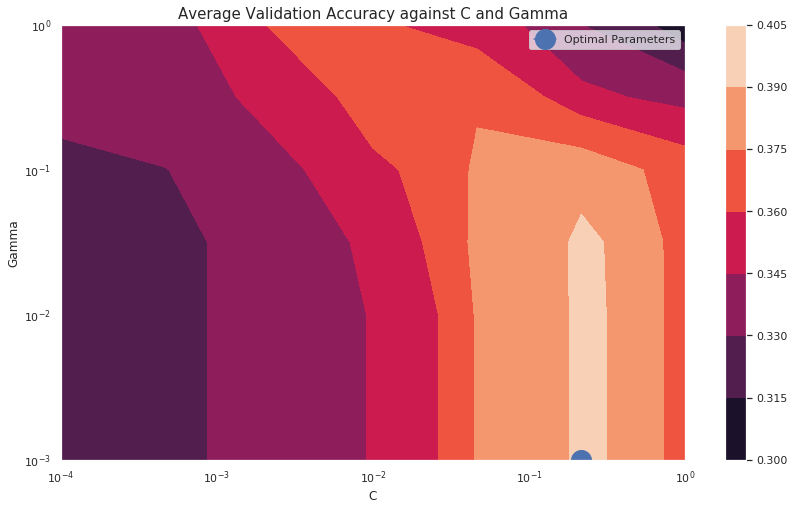

In [0]:
# Find optimal C and Gamma from search
indices = np.unravel_index(accuracy_vals.argmax(), accuracy_vals.shape)
rbf_C_best, rbf_gamma_best = C_list[indices[1]], gammas[indices[0]]

# Contour plot of C and Gamma
fig = plt.figure(figsize=(14,8))
plt.contourf(C_list, gammas, accuracy_vals)
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('C')
plt.ylabel('Gamma')
plt.title('Average Validation Accuracy against C and Gamma', fontsize=15)
plt.plot(rbf_C_best, rbf_gamma_best, marker='o', ms=20, label='Optimal Parameters')
plt.legend()
plt.show()


There seems to be some negative correlation between C and gamma from the plots, as thought. The optimal value of C and Gamma is also shows on the figure.

# Summary of SVM Models
The rbf kernel SVM model is chosen as the best model since it has the best validation accuracy. It is also relatively fast to train the hyperparameters compared to the linear and polynomial kernels. 
In summary, we have the following tuned hyperparameters for the three kernels:


In [174]:
# Populate table for tuned SVM models
rbf_C_best = 0.2154
rbf_gamma_best = 0.003
df_table = pd.DataFrame(columns=['Tuned SVM Model Kernel:', 'C', 'Gamma', 'Degree'])
df_table.loc[0] = ['Linear', linear_C_best, '-', '-']
df_table.loc[1] = ['Polynomial', poly_C_best, poly_gamma_best, poly_degree_best]
df_table.loc[2] = ['RBF', rbf_C_best, rbf_gamma_best, '-']
df_table

,Tuned SVM Model Kernel:,C,Gamma,Degree
0,Linear,0.177828,-,-
1,Polynomial,0.100000,0.1,2
2,RBF,0.215400,0.003,-


## Neural Networks

In [0]:
# Define the neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout=0):
        self.dropout = dropout
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        if self.training:
            out = F.dropout(out, p=self.dropout)
        out = self.fc3(out)
        return out

Note that Shuffle = True within the DataLoaders. This is to ensure that at each epoch, the neural network is fed in the data in different orders.

In [0]:
def eval_NN(X_train_full=X_train_full, y_train_full=y_train_full, folds=5, input_size=6,\
        hidden_size=200, num_classes=4, batch_size=64, learning_rate=0.01, num_epochs=120, dropout_rate=0):
    '''
    Evaluates accuracy (and loss) of neural networks using cross-validation
    '''
    accuracy_train = []
    accuracy_val = []
    
    # Set up CV
    if folds is not None:
        skf = StratifiedKFold(n_splits=folds, random_state=42)
    else:
        # Unused skf
        skf = StratifiedKFold(n_splits=2, random_state=42)

    # Call the NN
    net = NeuralNet(input_size, hidden_size, num_classes, dropout_rate)

    # Define Loss as Cross-Entropy
    criterion = nn.CrossEntropyLoss()

    # Use Stochastic Gradient Descent for the optimizer
    optimiser = torch.optim.SGD(net.parameters(), lr=learning_rate)  

    # Use stratified k-fold cross-validation to evaluate models
    if folds is not None:
        skf_split = skf.split(X_train_full, y_train_full)
    else:
        skf_split = [(0, 0)]

    accuracy_val = []
    for train_index, val_index in skf_split:
        if folds is not None:
            X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
            y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]
        else:
            X_train, X_val, y_train, y_val = X_train_full, X_train_full, y_train_full, y_train_full

        # Balance training set inside fold
        X_train, y_train = balance_data(X_train, y_train)

        # Fit standardisation scalers to training set for the cross-validation split
        # for each model during cross-validation
        Xscaler.fit(X_train)

        # Transform training and valiadtion data using the scaler that was fit on 
        # the training data for the cross-validation split
        X_train = Xscaler.transform(X_train)
        X_val = Xscaler.transform(X_val)
        
        # Create a tensor data set
        X_train, X_val = torch.from_numpy(X_train).float(), torch.from_numpy(X_val).float()
        y_train, y_val = torch.from_numpy(np.array(y_train)).float(), torch.from_numpy(np.array(y_val)).float()

        # Load data
        train = torch.utils.data.TensorDataset(X_train, y_train)
        train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

        val = torch.utils.data.TensorDataset(X_val, y_val)
        val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)

        # Train the model
        total_step = len(train_loader)
        loss_values = []

        for epoch in range(num_epochs+1):
            ###################
            # train the model #
            ###################
            net.train()
            train_loss = 0.0
            
            for i, (cars, labels) in enumerate(train_loader, 0):
                
                # reshape to long vector
                cars = cars.reshape(-1, 6)
                labels = labels.squeeze_().type(torch.LongTensor)
                    
                # forward pass
                outputs = net(cars)
                loss = criterion(outputs, labels)
                    
                # backward and optimise
                optimiser.zero_grad()
                loss.backward()
                optimiser.step()

                # Compute training loss
                train_loss += loss.item()

            # Store loss at each epoch
            loss_values.append(train_loss)

        # Calculate training accuracy after fully training nn
        y_train_pred = []
        net.eval()
        correct = 0
        total = 0
        for cars, labels in train_loader:
            cars = cars.reshape(-1, 6)
            labels = labels.squeeze_().type(torch.LongTensor)
            outputs = net(cars)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy_train.append(correct/total)

        # Calculate validation accuracy after fully training nn
        net.eval()
        correct = 0
        total = 0
        for cars, labels in val_loader:
            cars = cars.reshape(-1, 6)
            labels = labels.squeeze_().type(torch.LongTensor)
            outputs = net(cars)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy_val.append(correct/total)

    print('Finished Training')
    if folds is None: #remove?
        return loss_values, np.mean(accuracy_train), np.mean(accuracy_val) #, net # net trained on whole training set is returned if folds is None #REMOVE?
    else:
        return loss_values, np.mean(accuracy_train), np.mean(accuracy_val)

# Learning Rate
Neural networks for 3 learning rates are evaluated:

In [177]:
# Evaluate NN for different learning rates
learning_rates = [0.0005, 0.01, 0.95]

loss_values = np.zeros((3, 121))
accuracy_trains = np.zeros(3)
accuracy_vals = np.zeros(3)
for i, learning_rate in enumerate(learning_rates):

    # Evaluate NN (y classes must start from 0)
    loss_values[i, :], accuracy_trains[i], accuracy_vals[i] = eval_NN(y_train_full=y_train_full-1, learning_rate=learning_rate, folds=None)

Finished Training
Finished Training
Finished Training


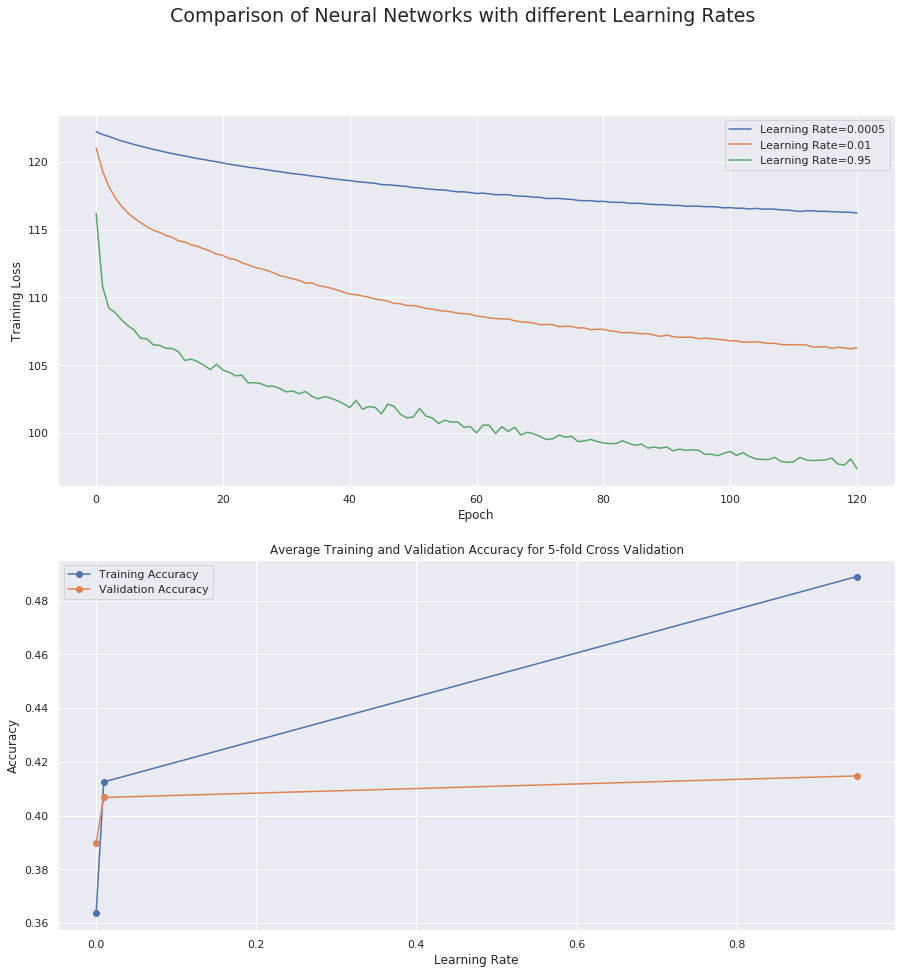

In [178]:
# Plot loss against epochs
fig, axes = plt.subplots(2, 1, figsize=(15,15))

# Plot graphs with different learning rates
for i in range(3):
    axes[0].plot(range(121), loss_values[i, :], label=f'Learning Rate={learning_rates[i]}')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].legend()

axes[1].plot(learning_rates, accuracy_trains, marker='o', label=f'Training Accuracy')
axes[1].plot(learning_rates, accuracy_vals, marker='o', label=f'Validation Accuracy')
axes[1].set_title('Average Training and Validation Accuracy for 5-fold Cross Validation')
axes[1].set_xlabel('Learning Rate')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

fig.suptitle('Comparison of Neural Networks with different Learning Rates', fontsize=19)
plt.show()

- The weights and biases of the neural network with a high learning rate (0.95) are updated too aggressively, such that the parameters jump around across the loss landscape without converging to (or convergence more slowly to) a minimum. This is illustrated in the high variance of the loss plotted against epochs.
- The neural network with the lower learning rate (0.0005) converges the slowest, since the weights and bias are updated too little each time so that the model doesn't change much each iteration. This can be seen in the figure, since the gradient is small.


# Batch Size
3 neural networks are evaualted for different batch sizes:

In [179]:
# Evaluate NN for different batch sizes using cross validation
batch_sizes = [2, 64, 256]
accuracy_trains = np.zeros(3)
accuracy_vals = np.zeros(3)

loss_values = np.zeros((3, 121))
for i, batch_size in enumerate(batch_sizes):

    # Evaluate NN
    loss_values[i, :], accuracy_trains[i], accuracy_vals[i] = eval_NN(y_train_full=y_train_full-1, batch_size=batch_size, folds=None)

Finished Training
Finished Training
Finished Training


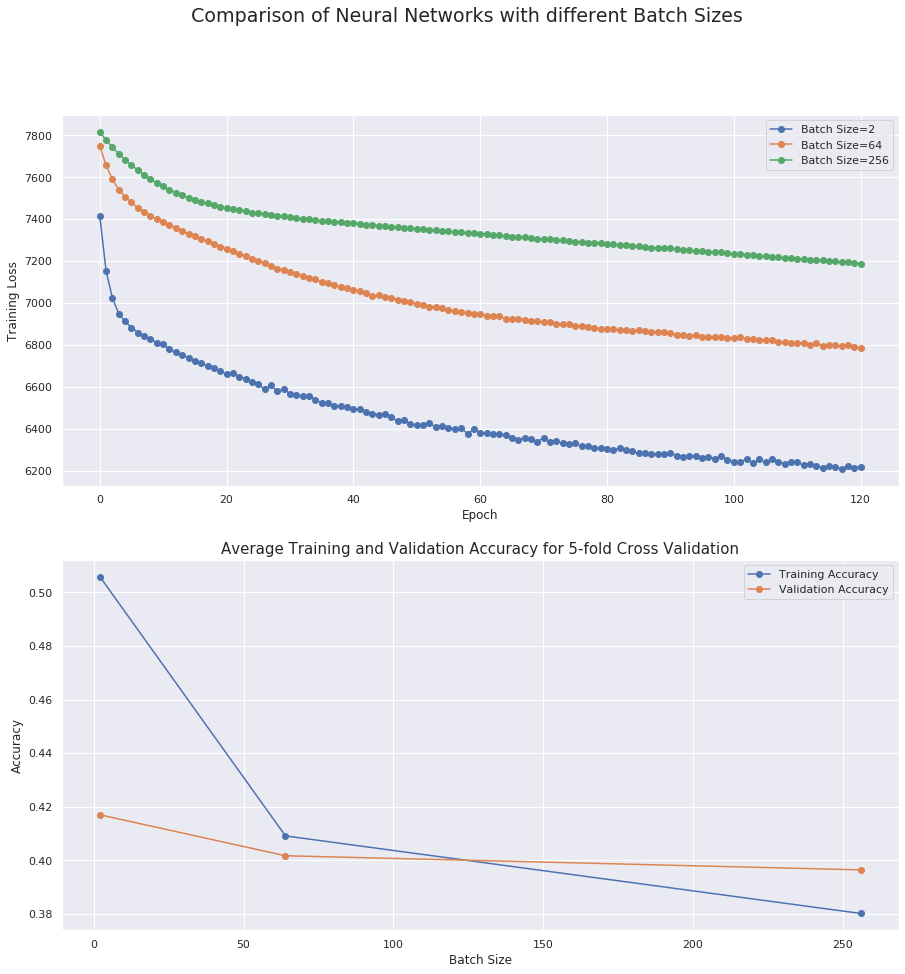

In [180]:
# Plot loss against epochs
fig, axes = plt.subplots(2, 1, figsize=(15,15))

# Plot graphs with different batch sizes
for i in range(3):
    axes[0].plot(range(121), loss_values[i, :]*batch_sizes[i], marker='o', label=f'Batch Size={batch_sizes[i]}')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].legend()

axes[1].plot(batch_sizes, accuracy_trains, marker='o', label=f'Training Accuracy')
axes[1].plot(batch_sizes, accuracy_vals, marker='o', label=f'Validation Accuracy')
axes[1].set_title('Average Training and Validation Accuracy for 5-fold Cross Validation', fontsize=15)
axes[1].set_xlabel('Batch Size')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

fig.suptitle('Comparison of Neural Networks with different Batch Sizes', fontsize=19)
plt.show()


- When the batch size is small, the batch that the neural network trains on might not be representative of the whole data, meaning that the weights and biases might not move in the right direction in terms of the loss landscape. This makes training noisy, and leads to a slower convergence. 
- When the batch size is high, the gradients estimated are likely better since the gradient is calculated for more points.
- The computation times for the lower batch sizes is also significantly higher. 

# Dropout Rate
- Dropout regularization in a neural network forces some neurons to be "switched off" randomly for each iteration, controlled by a dropout rate parameter. This prevents single neurons from being too highly weighted, which would lead to a model that is not very generalizable/predictive on out-of-sample data.
- The dropout rate for the second hidden layer is tuned:

In [0]:
# Evaluate NN for different dropout rates with cross validation
dropout_rates = np.linspace(0, 1, 15)

# Use numpy ndarrays to store model evaluations
accuracy_vals = np.zeros(len(dropout_rates))
accuracy_trains = np.zeros(len(dropout_rates))
loss_values = np.zeros((len(dropout_rates), 121))
for i, dropout_rate in enumerate(dropout_rates):
    print(dropout_rate)
    loss_values[i, :], accuracy_trains[i], accuracy_vals[i] = eval_NN(y_train_full=y_train_full-1, dropout_rate=dropout_rate)

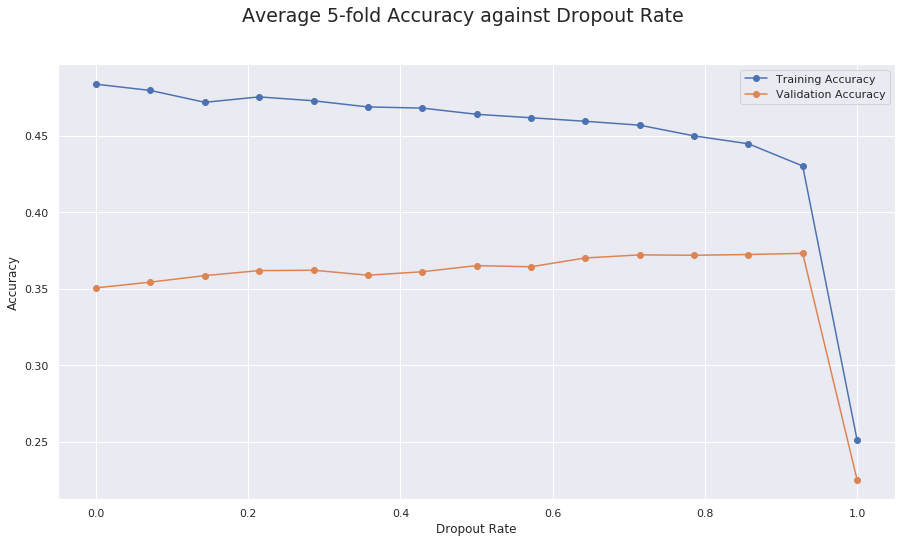

In [0]:
# Plot #no....
fig, ax = plt.subplots(1, 1, figsize=(15,8))

# Plot validation accuracy against dropout rate
ax.plot(dropout_rates, accuracy_trains, marker='o', label=f'Training Accuracy')
ax.plot(dropout_rates, accuracy_vals, marker='o', label=f'Validation Accuracy')
ax.set_xlabel('Dropout Rate')
ax.set_ylabel('Accuracy')
ax.legend()

fig.suptitle('Average 5-fold Accuracy against Dropout Rate', fontsize=19)
plt.show()

- The training accuracy decreases as the dropout rate increases, since the dropout rate forces dome neurons randomly to turn off, leading to worse in-sample predictions. However, the validation error increases quite steadily with increasing dropout rate (until the dropout rate is 1 and the model now has no predictive power). 
- This suggests that the neural network benefits from regularization of parameters (which increasing dropout rate enforces), leading to a more generalizable model.
- The optimal dropout rate is chosen to be 0.9

# Discussion
In this section, the three models with their respectively tuned hyperparameters using cross-validation are evaluated against the test data set. The training set evaluations will also be calculated, and these can be compared to identify any under/overfitting of the models. First, functions are written in order to concisely evaluate the models: 

In [0]:
def eval_metrics(clf, X_train, y_train, X_test, y_test):
    # Balance training set
    X_train, y_train = balance_data(X_train, y_train)

    # Standardize training and test data
    Xscaler.fit(X_train)
    X_train = Xscaler.transform(X_train)
    X_test = Xscaler.transform(X_test)

    # Fit model
    clf.fit(X_train, y_train)

    # Predict training data and test data
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    # Compute all metrics (in-sample and out-of-sample)
    train_metrics = {}
    test_metrics = {}

    train_metrics['confusion'] = confusion_matrix(y_train_pred, y_train)
    test_metrics['confusion'] = confusion_matrix(y_test_pred, y_test)

    train_metrics['accuracy'] = accuracy_score(y_train_pred, y_train)
    test_metrics['accuracy'] = accuracy_score(y_test_pred, y_test)
    
    train_metrics['precision'] = precision_score(y_train_pred, y_train, average='macro')
    test_metrics['precision'] = precision_score(y_test_pred, y_test, average='macro')

    train_metrics['recall'] = recall_score(y_train_pred, y_train, average='macro')
    test_metrics['recall'] = recall_score(y_test_pred, y_test, average='macro')

    train_metrics['f1'] = f1_score(y_train_pred, y_train, average='macro')
    test_metrics['f1'] = f1_score(y_test_pred, y_test, average='macro')

    # train_metrics['features'] = clf.feature_importances_

    return train_metrics, test_metrics

In [0]:
def eval_metrics_nn(X_train, y_train, X_test, y_test, input_size=6,hidden_size=200,\
    num_classes=4, batch_size=64, learning_rate=0.01, num_epochs=120, dropout_rate=0):
    
    # Call the NN
    net = NeuralNet(input_size, hidden_size, num_classes, dropout_rate)

    # Define Loss as Cross-Entropy
    criterion = nn.CrossEntropyLoss()

    # Use Stochastic Gradient Descent for the optimizer
    optimiser = torch.optim.SGD(net.parameters(), lr=learning_rate)  

    # Balance training set
    X_train, y_train = balance_data(X_train, y_train)

    # Fit standardisation scalers to training set for the cross-validation split
    # for each model during cross-validation
    Xscaler.fit(X_train)

    # Transform training and valiadtion data using the scaler that was fit on 
    # the training data for the cross-validation split
    X_train = Xscaler.transform(X_train)
    X_test = Xscaler.transform(X_test)
    
    # Create a tensor data set
    X_train, X_test = torch.from_numpy(X_train).float(), torch.from_numpy(X_test).float()
    y_train, y_test = torch.from_numpy(np.array(y_train)).float(), torch.from_numpy(np.array(y_test)).float()

    # Load data
    train = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

    test = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

    # Train the model on training set
    total_step = len(train_loader)
    loss_values = []

    for epoch in range(num_epochs+1):
        ###################
        # train the model #
        ###################
        net.train()
        # train_loss = 0.0
        
        for i, (cars, labels) in enumerate(train_loader, 0):
            
            # reshape to long vector
            cars = cars.reshape(-1, 6)
            labels = labels.squeeze_().type(torch.LongTensor)
                
            # forward pass
            outputs = net(cars)
            loss = criterion(outputs, labels)
                
            # backward and optimise
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

    print('Finished Training')

    # Compute in-sample metrics
    train_metrics = {}

    y_train_pred = []
    net.eval()
    correct = 0
    total = 0
    for cars, labels in train_loader:
        cars = cars.reshape(-1, 6)
        labels = labels.squeeze_().type(torch.LongTensor)
        outputs = net(cars)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_train_pred += predicted.tolist()
        
    
    train_metrics['accuracy'] = correct/total
    train_metrics['confusion'] = confusion_matrix(y_train_pred, y_train)
    train_metrics['precision'] = precision_score(y_train_pred, y_train, average='macro')
    train_metrics['recall'] = recall_score(y_train_pred, y_train, average='macro')
    train_metrics['f1'] = f1_score(y_train_pred, y_train, average='macro')
    # train_metrics['features'] = clf.feature_importances_

    # Compute out-of-sample metrics
    test_metrics = {}

    y_test_pred = []
    net.eval()
    correct = 0
    total = 0
    for cars, labels in test_loader:
        cars = cars.reshape(-1, 6)
        labels = labels.squeeze_().type(torch.LongTensor)
        outputs = net(cars)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_test_pred += predicted.tolist()
    
    test_metrics['accuracy'] = correct/total
    test_metrics['confusion'] = confusion_matrix(y_test_pred, y_test)
    test_metrics['precision'] = precision_score(y_test_pred, y_test, average='macro')
    test_metrics['recall'] = recall_score(y_test_pred, y_test, average='macro')
    test_metrics['f1'] = f1_score(y_test_pred, y_test, average='macro')

    return train_metrics, test_metrics

# Model Evaluations


In [192]:
t0 = time.time()
# NN
train_metrics_nn, test_metrics_nn = eval_metrics_nn(X_train_full, y_train_full-1, X_test_full, y_test_full-1, dropout_rate=0.9)
nn_time = time.time() - t0

t0 = time.time()
# RF
clf_rf = RandomForestClassifier(n_estimators=tree_num_best, max_depth=tree_depth_best, criterion="gini",\
    random_state=42, max_features=predictor_num_best, bootstrap=True, oob_score=True, n_jobs=-1)
train_metrics_rf, test_metrics_rf = eval_metrics(clf_rf, X_train_full, y_train_full, X_test_full, y_test_full)
rf_time = time.time() - t0


# SVM
t0 = time.time()
clf_svm_linear = svm.SVC(C=linear_C_best, kernel='linear')
linear_time = time.time() - t0

t0 = time.time()
clf_svm_poly = svm.SVC(C=poly_C_best, kernel='poly', gamma=poly_gamma_best, degree=poly_degree_best)
poly_time = time.time() - t0

t0 = time.time()
clf_svm_rbf = svm.SVC(C=rbf_C_best, kernel='rbf', gamma=rbf_gamma_best)
rbf_time = time.time() - t0

train_metrics_svm_linear, test_metrics_svm_linear = eval_metrics(clf_svm_linear, X_train_full, y_train_full, X_test_full, y_test_full)
train_metrics_svm_poly, test_metrics_svm_poly = eval_metrics(clf_svm_poly, X_train_full, y_train_full, X_test_full, y_test_full)
train_metrics_svm_rbf, test_metrics_svm_rbf = eval_metrics(clf_svm_rbf, X_train_full, y_train_full, X_test_full, y_test_full)

Finished Training


,Training Set Metrics,RF,SVM_linear,SVM_poly,SVM_rbf,NN
0,Accuracy,0.399,0.356,0.360,0.352,0.402
1,Precision,0.399,0.356,0.360,0.352,0.249
2,Recall,0.399,0.350,0.401,0.352,0.249
3,F1 Score,0.398,0.346,0.341,0.334,0.247
4,Training Time,0.855,0.000,0.000,0.000,18.188


In [193]:
# Populate table (training)
df_table = pd.DataFrame(columns=['Training Set Metrics', 'RF', 'SVM_linear', 'SVM_poly', 'SVM_rbf', 'NN'])
df_table.loc[0] = ['Accuracy', round(train_metrics_rf['accuracy'], 3), round(train_metrics_svm_linear['accuracy'], 3), round(train_metrics_svm_poly['accuracy'], 3), round(train_metrics_svm_rbf['accuracy'], 3), round(train_metrics_nn['accuracy'], 3), ]
df_table.loc[1] = ['Precision', round(train_metrics_rf['precision'], 3), round(train_metrics_svm_linear['precision'], 3), round(train_metrics_svm_poly['precision'], 3), round(train_metrics_svm_rbf['precision'], 3), round(train_metrics_nn['precision'], 3)]
df_table.loc[2] = ['Recall', round(train_metrics_rf['recall'], 3), round(train_metrics_svm_linear['recall'], 3), round(train_metrics_svm_poly['recall'], 3), round(train_metrics_svm_rbf['recall'], 3), round(train_metrics_nn['recall'], 3)]
df_table.loc[3] = ['F1 Score', round(train_metrics_rf['f1'], 3), round(train_metrics_svm_linear['f1'], 3), round(train_metrics_svm_poly['f1'], 3), round(train_metrics_svm_rbf['f1'], 3), round(train_metrics_nn['f1'], 3)]
df_table.loc[4] = ['Training Time', round(rf_time, 3), round(linear_time, 3), round(poly_time, 3), round(rbf_time, 3), round(nn_time, 3)]
df_table

,Training Set Metrics,RF,SVM_linear,SVM_poly,SVM_rbf,NN
0,Accuracy,0.399,0.356,0.360,0.352,0.402
1,Precision,0.399,0.356,0.360,0.352,0.249
2,Recall,0.399,0.350,0.401,0.352,0.249
3,F1 Score,0.398,0.346,0.341,0.334,0.247
4,Training Time,0.855,0.000,0.000,0.000,18.188


In [194]:
# Populate table (test)
df_table = pd.DataFrame(columns=['Test Set Metrics', 'RF', 'SVM_linear', 'SVM_poly', 'SVM_rbf', 'NN'])
df_table.loc[0] = ['Accuracy', round(test_metrics_rf['accuracy'], 3), round(test_metrics_svm_linear['accuracy'], 3), round(test_metrics_svm_poly['accuracy'], 3), round(test_metrics_svm_rbf['accuracy'], 3), round(test_metrics_nn['accuracy'], 3)]
df_table.loc[1] = ['Precision', round(test_metrics_rf['precision'], 3), round(test_metrics_svm_linear['precision'], 3), round(test_metrics_svm_poly['precision'], 3), round(test_metrics_svm_rbf['precision'], 3), round(test_metrics_nn['precision'], 3)]
df_table.loc[2] = ['Recall', round(test_metrics_rf['recall'], 3), round(test_metrics_svm_linear['recall'], 3), round(test_metrics_svm_poly['recall'], 3), round(test_metrics_svm_rbf['recall'], 3), round(test_metrics_nn['recall'], 3)]
df_table.loc[3] = ['F1 Score', round(test_metrics_rf['f1'], 3), round(test_metrics_svm_linear['f1'], 3), round(test_metrics_svm_poly['f1'], 3), round(test_metrics_svm_rbf['f1'], 3), round(test_metrics_nn['f1'], 3)]
df_table


,Test Set Metrics,RF,SVM_linear,SVM_poly,SVM_rbf,NN
0,Accuracy,0.577,0.494,0.440,0.470,0.540
1,Precision,0.538,0.452,0.413,0.420,0.513
2,Recall,0.536,0.452,0.432,0.426,0.513
3,F1 Score,0.533,0.447,0.373,0.401,0.507


- The Random Forest has the highest test set accuracy. The neural network also had a high test accuracy, suggesting that both these models were generalizable to out-of-sample data. The SVM models didn't generalize as well to the test data relative to the other models, suggesting that maybe they were overfit. This might be because we weren't able to perform as an exhaustive search on the hyperparameters as the random forest, since they took longer to train.
- Becuase of this, and the fact the random forest parameters seemed quite stable in the many plots, I would recommend this model to use for further predictions.
- Notably, the F1 score for the SVM polynomial model was low, meaning that there were many flase positives and negatives, further supporting the fact that this model was probably overfit. 
- The confusion matrices for the three tuned models are not shown, which give a feel for how each model classified the data.

Random Forest Confusion Matrix


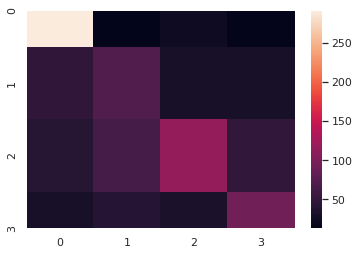

In [200]:
# The confusion matrices are plotted for each model
sns.heatmap(test_metrics_rf['confusion'])
print('Random Forest Confusion Matrix')


RBF SVM Confusion Matrix


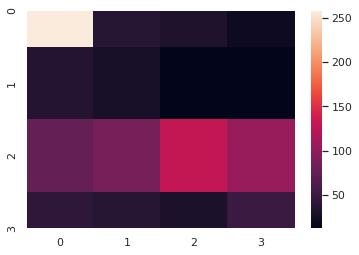

In [201]:
sns.heatmap(test_metrics_svm_rbf['confusion'])
print('RBF SVM Confusion Matrix')


Neural Network Confusion Matrix


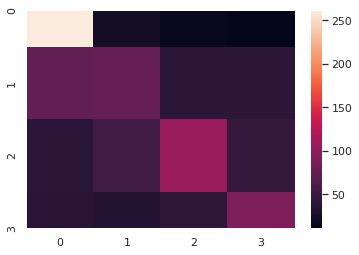

In [202]:
sns.heatmap(test_metrics_nn['confusion'])
print('Neural Network Confusion Matrix')


# Suitability of Models
- The neural network is probably the least appropriate model given the low dimensionality (6) of the data, since it is very complex (many parameters), and as shown by the lower test accuracy, it tends to overfit. 
- The best rbf SVM model has a high test set accuracy and was quite easy to train due to the small number of predictors. Becuase of the small number of predictors, the model becomes more interpretable, with explainable coefficients returned by the model.
- Overall, the random forest and the SVM RBF models seem to be the most sensible ones to try and tune, based on the smaller parameter space and interpretability of the parameters. They also take much shorted time to train compared to the neural network.